## Import Required Libraries

In [14]:
import numpy as np
from scipy.integrate import odeint
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import gaussian_kde,ecdf
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import time

In [15]:
def print_statistics(data, name):
    mean = np.mean(data)
    median = np.median(data)
    std_dev = np.std(data)
    minimum = np.min(data)
    maximum = np.max(data)
    quartiles = np.percentile(data, [25, 50, 75])

    print(f"Statistics for {name}:")
    print(f"Mean: {mean:.4f}")
    print(f"Median: {median:.4f}")
    print(f"Standard Deviation: {std_dev:.4f}")
    print(f"Minimum: {minimum:.4f}")
    print(f"Maximum: {maximum:.4f}")
    print(f"25th percentile: {quartiles[0]:.4f}")
    print(f"50th percentile: {quartiles[1]:.4f}")
    print(f"75th percentile: {quartiles[2]:.4f}")
    print("\n")

## combined_model function

In [16]:
def combined_model(I_net, M_net, c_net, z_net, tspan, init_conds):
    I_uncertainty = 0
    M_uncertainty = 0
    l_uncertainty = 0
    g_uncertainty = 0.0
    viscous_uncertainty = 0
    friction_uncertainty = 0
    noise_const = np.deg2rad(0.04, dtype=np.float128) #note that if you turn this to zero things appear to shit themselves
    Init_conds_uncertainty = [0, 0]

    I = np.float128(I_net) + ((2 * np.random.rand() - 1) * I_uncertainty)
    M = np.float128(M_net) + ((2 * np.random.rand() - 1) * M_uncertainty)
    l = 1 + ((2 * np.random.rand() - 1) * l_uncertainty)
    r = (.75 / 2) + ((2 * np.random.rand() - 1) * l_uncertainty)
    g = 9.7949 + ((2 * np.random.rand() - 1) * g_uncertainty)
    c = c_net + ((2 * np.random.rand() - 1) * viscous_uncertainty)
    z = z_net + ((2 * np.random.rand() - 1) * friction_uncertainty)
    ics = init_conds + ((2 * np.random.rand(2) - 1) * Init_conds_uncertainty)

    paramsTrue = [I, M, g, r, l, c, z]

    def combined_system(T, t):
        I, M, g, r, l, c, z = paramsTrue
        tdot1 = T[1]
        tdot2 = ((-z * np.sign(T[1])) - (c * T[1]) - ((M * g * r ** 2 / l) * T[0])) / I
        return [tdot1, tdot2]

    theta_m = odeint(combined_system, ics, tspan)
    noise = noise_const * (2 * np.random.rand(len(theta_m[:, 0])) - 1)

    theta = theta_m + noise[:, None]
    return tspan, theta


## viscous_parameters_solver function

In [31]:
def viscous_parameters_solver(t, theta):
    l = 1.0
    r = .75 / 2
    g = 9.7949
    mnet = 3
    noise_param = 0.04
    # Filter the data
    b, a = butter(4, 0.05, 'low')
    filtered_theta = filtfilt(b, a, theta)
    peak_filtering_param = 3 #remember to adjust as to remove outliers associated with signal noise

    # Use find_peaks with adjusted parameters to identify peaks
    peaks, _ = find_peaks(filtered_theta, prominence=np.deg2rad(noise_param*peak_filtering_param))  # adjust prominence if needed

    # Check if peaks are found
    if len(peaks) == 0:
        print("No peaks were found.")
        return [0, 0, 0, 0]

    # Calculate the periods between peaks
    periods = np.diff(t[peaks])
    # plt.figure()
    # plt.plot(t,theta,'kx',ms=1)
    # plt.plot(t,filtered_theta,'r-')
    # plt.xlim((0,15))
    # plt.show()
    # plt.figure()
    # plt.plot(periods)
    # plt.show()
    # Calculate median filtered period
    T_d = np.median(periods)
    # print(f"T_d = {T_d}", end='\n')
    omega_d = (2 * np.pi) / T_d
    # print(f"Calculated wd = {omega_d}", end='\n')

    # Calculate the damping ratio
    amplitude_ratios = filtered_theta[peaks][1:] / filtered_theta[peaks][:-1]
    damping_ratios = -1*np.log(amplitude_ratios)
    # print(f"Calculated dr = {np.median(damping_ratios)}",end='\n')
    zeta = np.median(damping_ratios) / ( np.sqrt( (4 * np.pi ** 2) + (np.median(damping_ratios) ** 2) ) )
    # print(f"Calculated zeta = {zeta}",end='\n')

    # Calculate natural frequency and inertia
    omega_n = omega_d / np.sqrt(1 - zeta ** 2)
    Inet_pure = (mnet * g * r ** 2) / (l * omega_n ** 2)
    c_pure = zeta * 2 * np.sqrt(Inet_pure * ((mnet * g * r ** 2) / l))

    return [Inet_pure, (mnet * g * r ** 2) / l, c_pure, 0,len(damping_ratios)]


## viscousModel function

In [18]:
def viscous_model(I_net, M_net, c_net, z_net, tspan, init_conds):
    I = I_net
    m = M_net
    c = c_net
    x0 = init_conds[0]
    v0 = init_conds[1]
    r = .75/2
    l = 1.0
    g = 9.7949
    z = z_net #dummy variable so that viscousModel and combinedModel can have the same function call

    wn = np.sqrt((m * g * r ** 2.0 / l) / I)
    zeta = c / (2*np.sqrt((m * g * r ** 2.0 / l) * I))
    wd = wn * np.sqrt(1.0 - zeta ** 2.0)
    A = np.sqrt(((v0 + wn * zeta * x0) ** 2.0 + (x0 * wd) ** 2) / wd ** 2.0)
    phi = np.arctan((x0 * wd) / (v0 + wn * zeta * x0))
    pos = A * np.multiply(np.exp(-zeta * wn * tspan),np.sin(wd * tspan + phi))
    vels = np.zeros(len(tspan))
    s = (len(tspan),2)
    theta_m = np.zeros(s)
    theta_m[:,0] = pos
    theta_m[:,1] = vels
    noise = np.deg2rad(0.04) * (2 * np.random.rand(len(theta_m[:, 0])) - 1)
    theta = theta_m + noise[:, None]
    return tspan,theta

## combinedModel Usage

In [19]:

result_I = np.zeros(1000)
percent_error = np.zeros(1000)

I_xx_xy_init = np.float128(0.02089)
I_disk = np.float128(0.5) * 2 * ((np.float128(0.75) / 2) ** 2)

# for i in range(1000):
#     t1, theta1 = combined_model(I_xx_xy_init + I_disk, 3, 0.01, 0, np.linspace(0, 10, 10000), [np.deg2rad(5), 0])
#     params_test = viscous_parameters_solver(t1, theta1[:, 0])
#     result_I[i] = params_test[0] - I_disk
#     percent_error[i] = ((result_I[i] - I_xx_xy_init) / I_xx_xy_init) * 100
#     # print(i + 1)


## viscousResponse usage

In [20]:
# for i in range(1000):
#     t1,theta1 = viscous_model(I_xx_xy_init + I_disk, 3.0, 0.01, 0, np.linspace(0, 10, 10000), [np.deg2rad(5), 0])
#     params_test = viscous_parameters_solver(t1, theta1[:,0])
#     result_I[i] = params_test[0] - I_disk
#     percent_error[i] = ((result_I[i] - I_xx_xy_init) / I_xx_xy_init) * 100
#     # print(i + 1)

## Creating KDE Plots

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# # KDE plot for result_I
# kde_result_I = gaussian_kde(result_I)
# xi = np.linspace(0.01, 0.03, 1000)
# plt.figure()
# plt.plot(xi, kde_result_I(xi), color='blue')
# plt.xlabel('Measured Moment of Inertia')
# plt.ylabel('Density Estimate')
# plt.title('KDE Estimate of Accuracy of Simulated Inertia Tests')
# plt.xlim([0.01, 0.03])
# plt.axvline(x=0.02089, color='r', label='Actual Value')
# plt.axvline(x=np.median(result_I), color='k', label='Median Calculated Value')
# plt.legend()
# plt.show()

# # Print statistics for result_I
# print_statistics(result_I, "Result I")

# # KDE plot for percent_error
# kde_percent_error = gaussian_kde(percent_error)
# xi = np.linspace(min(percent_error), max(percent_error), 1000)
# plt.figure()
# plt.plot(xi, kde_percent_error(xi), color='purple')
# plt.xlabel('% Error')
# plt.ylabel('Density Estimate')
# plt.title('KDE Estimate of Accuracy of Simulated Inertia Tests')
# plt.axvline(x=np.median(percent_error), color='k', label='Median Calculated Value')
# plt.axvline(x=0, color='r', label='Actual Value')
# plt.legend()
# plt.show()

# # Print statistics for percent_error
# print_statistics(percent_error, "Percent Error")

# Testing Solver Accuracies

In [22]:

# # I_xx = .020833
# # I_yy = .028333
# # I_zz = .003416

# I_xx_xy_init = 0.02089
# # I_yy_xy_init = 0.028276
# # I_xx_xz_init = 0.020858
# # I_zz_xz_init = 0.03413
# # I_yy_yz_init = 0.028349
# # I_zz_yz_init = 0.03414

# # I_xx_xy_p = 0.0233
# # I_yy_xy_p = 0.025866
# # I_xx_xz_p = 0.02468
# # I_zz_xz_p = 0.030313
# # I_yy_yz_p = 0.030061
# # I_zz_yz_p = 0.03242

# I_disk = 0.5 * 2 * ((.75 / 2) ** 2)

# trials_per_test = np.array([1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40]) 
# num_test_points = len(trials_per_test)
# num_tests_per_point = 60
# low = np.zeros(num_test_points)
# high = np.zeros(num_test_points)
# totalTrials = sum(trials_per_test*num_tests_per_point)
# counter = 0

# # Start timing
# start_time = time.time()

# for i in range(num_test_points):
#     avg_per_test = np.zeros(num_tests_per_point)
#     for j in range(num_tests_per_point):
#         percent_error = np.zeros(trials_per_test[i])
#         for x in range(trials_per_test[i]):
#             t1, theta1 = viscous_model(np.float128(I_xx_xy_init) + I_disk, np.float128(3), np.float128(0.1), np.float128(0), np.linspace(np.float128(0), np.float128(10), 10000, dtype=np.float128), [np.deg2rad(np.float128(5), dtype=np.float128), np.float128(0)])
#             params_test = viscous_parameters_solver(t1, theta1[:, 0])
#             result_I = params_test[0] - I_disk
#             percent_error[x] = ((result_I - I_xx_xy_init) / I_xx_xy_init) * 100
#             print(f"\rComputation {(counter/totalTrials)*100:.2f}% Completed", end='')
#             counter = counter+1
#         avg_per_test[j] = np.mean(percent_error)
#     xi = np.linspace(np.min(avg_per_test), np.max(avg_per_test), 1000)
#     f_init = ecdf(avg_per_test).cdf.probabilities
#     f_spline = CubicSpline(np.linspace(np.min(avg_per_test), np.max(avg_per_test), num_tests_per_point),f_init)
#     f = f_spline(xi)

#     foundlow = False
#     for n in range(len(f)):
#         if f[n] > 0.025 and not foundlow:
#             low[i] = xi[n]
#             foundlow = True
#         if f[n] > 0.975 and foundlow:
#             high[i] = xi[n]
#             break

# plt.figure()
# plt.plot(trials_per_test, low, color='blue',label='2.5% Lower Bound')
# plt.plot(trials_per_test, high, color='green',label='5% Upper Bound')
# plt.title('95% CI of %Error of Inertia Measurement')
# plt.xlabel('Number of Trials')
# plt.ylabel('Percent Error')
# plt.axhline(y=0,color='black',linestyle='--')
# plt.axhline(y=.5, color='red',linestyle='--',lw='.2')
# plt.axhline(y=-.5,color='red',linestyle='--',lw='.2')
# plt.axhline(y=1, color='red',linestyle='--',lw='.2')
# plt.axhline(y=-1,color='red',linestyle='--',lw='.2')
# plt.legend()
# plt.show()

# # End timing
# end_time = time.time()

# # Calculate and print the total time
# total_time = end_time - start_time
# print(f"Total calculation time: {total_time} seconds")

In [23]:
visc_damp = 0.1
t1, theta1 = viscous_model(0.02089+(0.5 * 2 * ((.75 / 2) ** 2)), 3, visc_damp, 0.0, np.linspace(0, 15, 10000), [np.deg2rad(5), 0])
t2,theta2 = combined_model(0.02089+(0.5 * 2 * ((.75 / 2) ** 2)), 3, visc_damp, 0.0, np.linspace(0, 15, 10000), [np.deg2rad(5), 0])

error = np.zeros(1000)
dampings = np.linspace(0,0.3,num=1000)
for i in range(1000):
    t,theta = viscous_model(0.02089+(0.5 * 2 * ((.75 / 2) ** 2)), 3, dampings[i], 0.0, np.linspace(0, 15, 10000), [np.deg2rad(5), 0])
    zeta_act = (dampings[i])/(2*np.sqrt(4.13332*(0.02089+(0.5 * 2 * ((.75 / 2) ** 2)))))
    I,k,c,_=viscous_parameters_solver(t,theta[:,0])
    zeta_pred = c/(2*np.sqrt(k*I))
    error[i]=(zeta_act-zeta_pred)/zeta_pred

plt.figure()
# plt.plot(error)
plt.plot(dampings, error)
plt.show()
plt.figure(figsize=(10,10))
plt.plot(t1,theta1[:,0],marker='o',ms=1,label='Viscous Response')
plt.plot(t2,theta2[:,0],marker='x',ms=1,label='Combined Response')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Theta [radians]')

/tmp/ipykernel_13431/1335514325.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  phi = np.arctan((x0 * wd) / (v0 + wn * zeta * x0))


ValueError: too many values to unpack (expected 4)

## Solver Checking

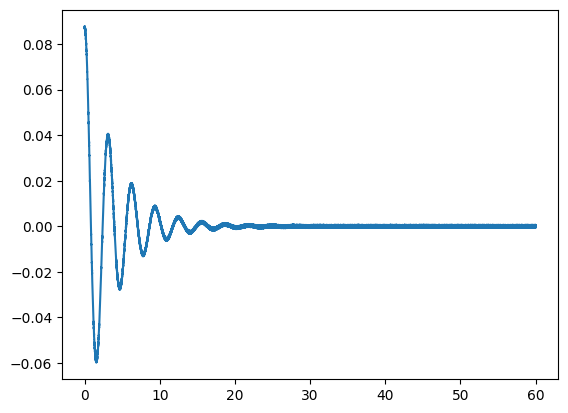

No peaks were found.


ValueError: not enough values to unpack (expected 5, got 4)

In [32]:
I_true = 1
M_true = 3
c_true = 0.01
z_true = 0
t,theta = viscous_model(I_true,M_true,c_true,z_true,np.linspace(0,15,10000),[np.deg2rad(5),0])
paramsMeasured = viscous_parameters_solver(t,theta[:,0])
k_true = M_true*9.7949*(.75/2)**2
wn_true = np.sqrt(k_true/I_true)


n_trials = 10000
error = np.zeros(n_trials)
dampings = np.linspace(.01,2.5,num=n_trials)
zeta_pred = np.zeros(n_trials)
zeta_true = np.zeros(n_trials)
wd_pred = np.zeros(n_trials)
wd_true = np.zeros(n_trials)
wn_pred = np.zeros(n_trials)
wn_true = np.zeros(n_trials)
numPeaks = np.zeros(n_trials)

t,theta = viscous_model(I_true, M_true, 0.5, 0.0, np.linspace(0, 60, 20000), [np.deg2rad(5), 0])
plt.figure()
plt.plot(t,theta[:,0])
plt.show()

for i in range(n_trials):
    t,theta = combined_model(I_true, M_true, dampings[i], 0.0, np.linspace(0, 60, 20000), [np.deg2rad(5), 0])
    zeta_true[i] = dampings[i]/(2*np.sqrt(k_true*I_true))
    I,k,c,_,numPeaks[i] =viscous_parameters_solver(t,theta[:,0])
    zeta_pred[i] = c/(2*np.sqrt(k*I))
    error[i]=((zeta_true[i]-zeta_pred[i])/zeta_pred[i])*100

plt.figure(figsize=(10,10))
plt.scatter(zeta_true,error,marker='x',s=5,c=np.abs(numPeaks))
plt.axhline(y=0,c='k',linestyle='-')
plt.title('ζ Value vs Percent Error in ζ Estimation')
plt.xlabel('ζ')
plt.ylabel('%Error in ζ Calculation')
plt.ylim((-10,10))
plt.show()

kde_result_I = gaussian_kde(error)
xi = np.linspace(np.min(error), np.max(error), 1000)
plt.figure()
plt.plot(xi, kde_result_I(xi), color='black',linestyle='-',linewidth=2)
plt.xlim((-10,10))
plt.axvline(x=0,c='k',linestyle='--',linewidth=0.5)
plt.axvline(x=np.mean(error),c='k',linestyle='-',linewidth=2)
plt.title('KDE Estimate of %Error of Zeta Estimation')
plt.xlabel('%Error in Zeta Calculation')
plt.ylabel('KDE Estimate')
plt.show()



# zeta_true = c_true/(2*np.sqrt(k_true*I_true))
# print(f"True zeta = {zeta_true}", end='\n')

# print(f"True wn = {wn_true}", end='\n')
# wd_true = wn_true*np.sqrt(1-zeta_true**2)
# print(f"True wd = {wd_true}", end='\n')
# dr_true = (2*np.pi*zeta_true)/(np.sqrt(1-zeta_true**2))
# print(f"True dr = {dr_true}", end='\n')


